In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [79]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

# 파이토치 사용할때 커널 충돌 문제 해결

In [80]:
mnist_train = datasets.MNIST('MINIST_data', 
                             train = True, 
                             download=True, 
                             transform=transforms.Compose([transforms.ToTensor()])) # train data를 가져옴

mnist_test = datasets.MNIST('MINIST_data', 
                             train = False, # False로 설정하면 test data를 가져옴
                             download=True, 
                             transform=transforms.Compose([transforms.ToTensor()])) # test data를 가져옴

In [81]:
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MINIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: MINIST_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [82]:
# 데이터 이미지 확인

def plot(x): 
    img=(np.array(x.detach(), dtype='float')).reshape(28,28)
    plt.imshow(img, cmap='grey')
    plt.show()

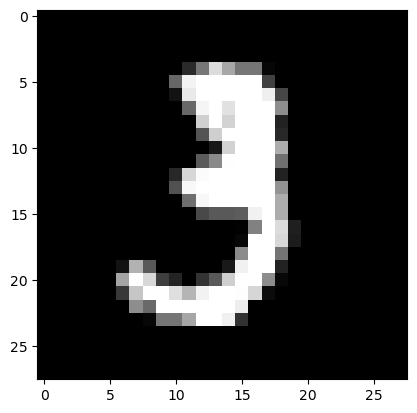

In [83]:
plot(mnist_train.data[10])

In [84]:
print(mnist_train.targets[10]) # tensor로 출력

tensor(3)


In [85]:
print(mnist_train.targets[10])
print(mnist_train.data.shape)
print(mnist_train.targets.shape)

tensor(3)
torch.Size([60000, 28, 28])
torch.Size([60000])


In [86]:
x = mnist_train.data[10]
x

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [87]:
# 0 ~ 1 사이의 값으로 정규화

x = mnist_train.data.float() / 255 # 데이터 스케일 조정
#x[0] 
y = mnist_train.targets
#y[:10] 

print(x.size())
print(y.size())
x=x.view(x.size(0),-1) # 2차원 데이터를 1차원으로 변환

input_size = x.size(-1) # -1은 마지막 차원을 의미. 입력데이터 크기
print(input_size) 
output_size=int(max(y))+1 # 제일 큰 값에 1을 더해줌 => 10. 출력데이터 크기
print(output_size)

torch.Size([60000, 28, 28])
torch.Size([60000])
784
10


In [94]:
#훈련 데이터(train)와 검증 데이터(valid) 분리

ratio = [0.8, 0.2] # 훈련 데이터와 검증 데이터 비율
train_cnt=int(x.size(0)*ratio[0]) # 훈련 데이터 개수
valid_cnt=int(x.size(0)*ratio[1]) # 검증 데이터 개수
test_cnt=len(mnist_test.data) # 테스트 데이터 개수

print(train_cnt, valid_cnt, test_cnt)
cnts=[train_cnt, valid_cnt]

indices=torch.randperm(x.size(0)) # 데이터 인덱스 섞기 위해 랜덤으로 섞음 

#print(indices[0:20])

x=torch.index_select(x, dim=0, index=indices) # 데이터 섞음
y=torch.index_select(y, dim=0, index=indices) # y도 인덱스 맞춰서 섞음
#plot(x[0]) # 데이터 확인 -> 섞인 데이터 확인 가능
#y[0] # x[0]에 대한 y값 맞춰짐 

x1=list(x.split(cnts, dim=0)) # 데이터 분할
y1=list(y.split(cnts, dim=0)) # y값도 데이터 분할
print(x1[0].shape, x1[1].shape) # 훈련, 검증, 테스트 데이터 개수 확인
print(y1[0].shape, y1[1].shape) # 훈련, 검증, 테스트 데이터 개수 확인

x1+=[(mnist_test.data.float()/255).view(test_cnt, -1)]
y1+=[mnist_test.targets]

for ii in x1:
    print(ii.shape)

for yi in y1:
    print(yi.shape)



80 20 10000
torch.Size([80, 1]) torch.Size([20, 1])
torch.Size([80, 1]) torch.Size([20, 1])
torch.Size([80, 1])
torch.Size([20, 1])
torch.Size([10000, 784])
torch.Size([80, 1])
torch.Size([20, 1])
torch.Size([10000])


In [97]:
model=nn.Sequential(
    nn.Linear(input_size, 500), # 입력층
    nn.LeakyReLU(),
    nn.Linear(500, 400), # 은닉층 ( 앞의 값의 뒤 값과 은닉층 값의 앞 값이 같아야함)
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size), # 출력층
    nn.Softmax(dim=-1) # 출력층의 활성화 함수
)
model


Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): Softmax(dim=-1)
)

In [98]:
# 모델 훈련

crit = nn.CrossEntropyLoss() # 손실함수
optimizer = optim.Adam(model.parameters()) # 옵티마이저 


In [99]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [100]:
model = model.to(device) # 모델을 gpu로 보냄 -> cuda 사용할때 설정 필요
x2=[x_i.to(device) for x_i in x1]
y2=[y_i.to(device) for y_i in y1]


In [101]:
# 훈련

epochs = 1000
batch_size = 256 # 배치 사이즈(한번에 학습시킬 데이터 양)
print_interval = 10 # 출력 간격

In [103]:
# 새로운 데이터 넣었을때 가장 낮은 loss값을 가진 모델을 저장하기 위한 변수


from copy import deepcopy # 모델 복사

lowest_loss = np.inf # 가장 낮은 loss값을 저장하기 위한 변수 
bast_model=None

early_stop = 50  # 50번 이상 loss값이 증가하면 학습 종료 
lowest_epoch = np.inf # 가장 낮은 loss값을 가진 epoch 저장 

In [104]:
y2[:10] # y값 확인 -> 1차원. 2차원으로 만들어야함 

[tensor([[ 62.],
         [ 92.],
         [ 86.],
         [ 96.],
         [144.],
         [158.],
         [194.],
         [ 88.],
         [ 90.],
         [ 44.],
         [ 12.],
         [150.],
         [ 40.],
         [ 42.],
         [172.],
         [152.],
         [108.],
         [ 36.],
         [ 94.],
         [ 16.],
         [104.],
         [174.],
         [ 68.],
         [  8.],
         [ 70.],
         [ 98.],
         [162.],
         [196.],
         [  2.],
         [ 58.],
         [110.],
         [ 54.],
         [148.],
         [112.],
         [182.],
         [106.],
         [156.],
         [  6.],
         [166.],
         [ 78.],
         [132.],
         [124.],
         [ 56.],
         [ 14.],
         [100.],
         [ 22.],
         [134.],
         [ 26.],
         [188.],
         [130.],
         [ 28.],
         [ 80.],
         [128.],
         [  4.],
         [ 38.],
         [126.],
         [178.],
         [ 82.],
         [ 34.

In [105]:
# 훈련 시작

train_history, valid_history = [], []

for i in range(epochs) :
    indices=torch.randperm(x2[0].size(0)).to(device) # 데이터 섞기
    x_=torch.index_select(x2[0], dim=0, index=indices) # x 훈련 데이터 섞음
    y_=torch.index_select(y2[0], dim=0, index=indices) # y값도 섞음

    x_=x_.split(batch_size, dim=0) # 배치 사이즈로 데이터 나눔
    y_=y_.split(batch_size, dim=0) # 배치 사이즈로 y값 나눔

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_) : # zip 함수를 사용하여 x와 y값을 묶어서 tensor로 변환
        y_hat_i = model(x_i) # 모델에 x값 넣어서 y값 예측
        loss = crit(y_hat_i, y_i.squeeze()) # y_i를 2차원으로 만들어서 loss값 계산

        optimizer.zero_grad() # 기울기 초기화
        loss.backward()
        optimizer.step()
        train_loss+=float(loss) # loss값 계산

    train_loss= train_loss/len(x_) # loss값 계산. len(x_)는 배치 사이즈로 나눈 값(4800/256)

    with torch.no_grad(): # 검증 데이터는 기울기 계산 필요없음
        x_=x2[1].split(batch_size, dim=0) # 검증 데이터 배치 사이즈로 나눔 -> 똑같은 사이즈로 만들기위해 
        y_=y2[1].split(batch_size, dim=0) 

        for x_i, y_i in zip(x_, y_) :
            y_hat_i=model(x_i) # 모델에 x값 넣어서 y값 예측
            loss=crit(y_hat_i, y_i) # loss값 계산
            valid_loss+=float(loss) 

            y_hat+=[y_hat_i] 
    valid_loss=valid_loss/len(x_i) # loss값 계산

    train_history+= [train_loss] # 훈련 데이터 loss값 저장
    valid_history+= [valid_loss] # 검증 데이터 loss값 저장

    #출력
    if (i+1) % print_interval == 0:
        print(i, train_loss, valid_loss, lowest_loss) # epoch, 훈련 데이터 loss값, 검증 데이터 loss값 출력

    if valid_loss <= lowest_loss: # 검증 데이터 loss값이 가장 낮을때 모델 저장
        lowest_loss = valid_loss
        lowest_epoch = i
        bast_model = deepcopy(model.state_dict()) # 작은 값 구해질때마다 모델 저장



      




RuntimeError: mat1 and mat2 shapes cannot be multiplied (80x1 and 784x500)